# Imports

In [1]:
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import _DistanceMatrix
from Bio.Phylo import draw
from Bio import SeqIO
from Bio import Phylo, AlignIO
import subprocess
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import math
import scipy.linalg as la
#from skbio import DistanceMatrix

# Read sequence data and metadata
Read in the SARS-CoV-2 multiple sequence alignment.

47 SARS-CoV-2 genomic sequences from different locations and hosts were retrieved from NCBI Virus and aligned using the alignment function provided by the platform (https://www.ncbi.nlm.nih.gov/labs/virus/vssi/).

MSA.fasta was created by replacing the sequence header of the downloaded ncbi msa file with only the accession id and the file suffix -aln with .fasta.

### Transform Sequence into graph

In [53]:
n=0.5
m=0.75
def calculateXY(seq):
    A_i=0
    C_i=0
    G_i=0
    T_i=0
    i=0
    X=[]
    Y=[]
    for ch in seq:
        if ch=='A':
            A_i+=1
        if ch=='C':
            C_i+=1
        if ch=='G':
            G_i+=1
        if ch=='T':
            T_i+=1
        X.append(A_i*m+G_i*math.sqrt(n)+C_i*math.sqrt(n)+T_i*m)
        Y.append(A_i*math.sqrt(n)*(-1)-G_i*m+C_i*m+T_i*math.sqrt(n))
        i+=1
    return X, Y


In [54]:
def calAllXY(SeqO):
    AllX=[]
    AllY=[]
    for seq_i in SeqO:
        Xi,Yi = calculateXY(seq_i)
        AllX.append(Xi)
        AllY.append(Yi)
    return AllX, AllY

### Read the unaligned sequences and process them

In [55]:
sequences = SeqIO.parse("sequences47.fasta", "fasta")
Xs, Ys = calAllXY(sequences)

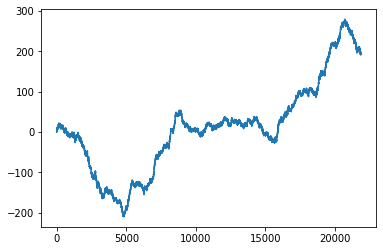

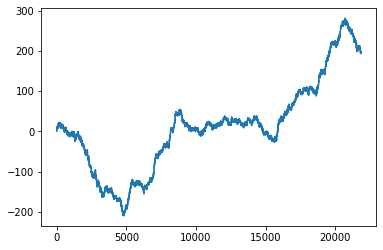

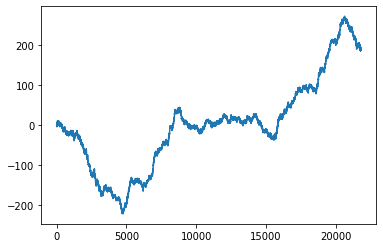

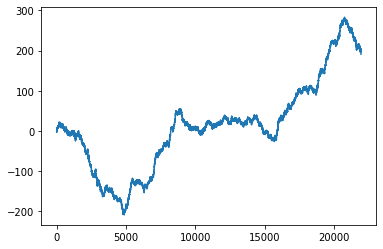

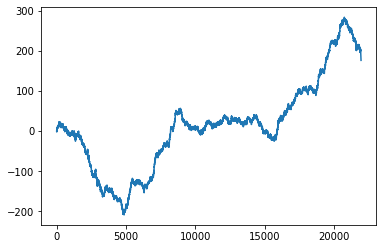

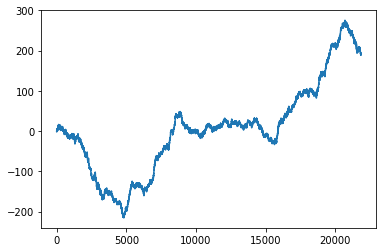

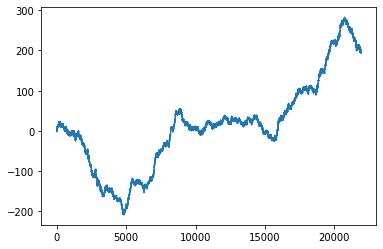

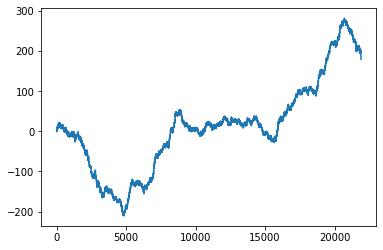

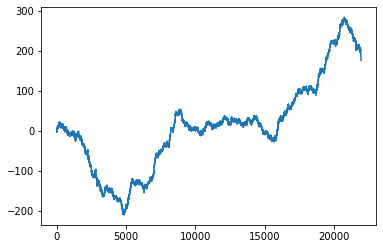

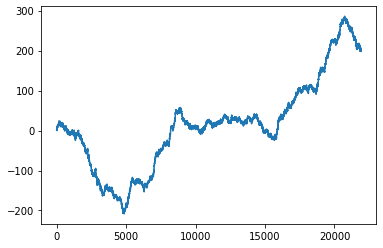

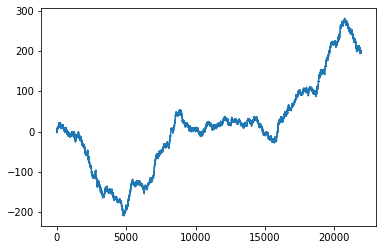

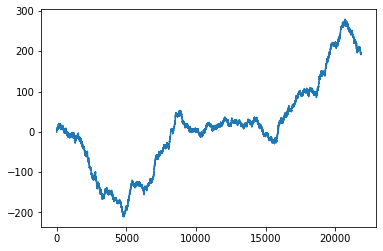

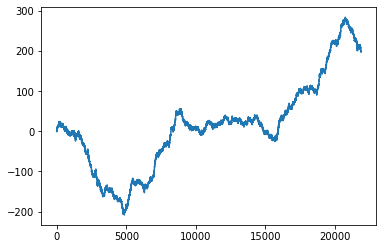

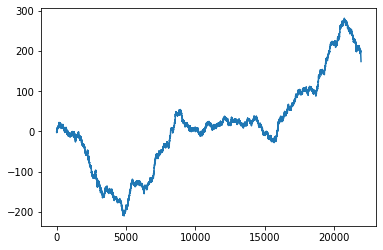

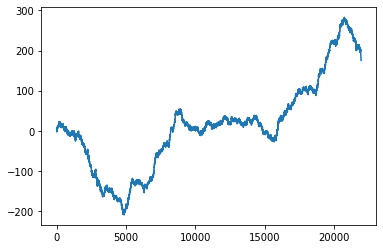

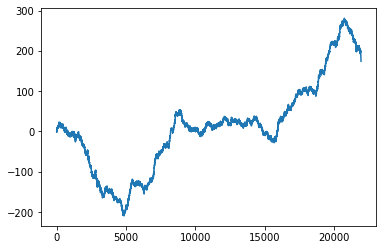

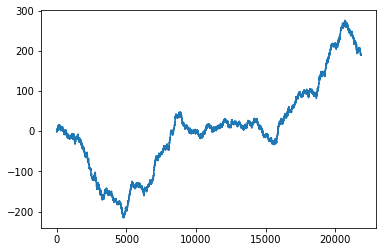

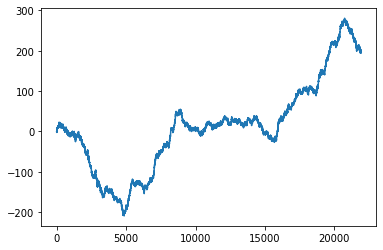

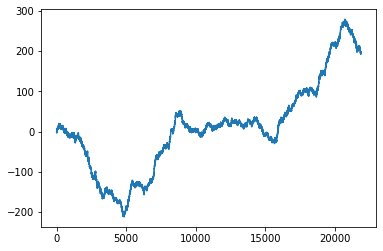

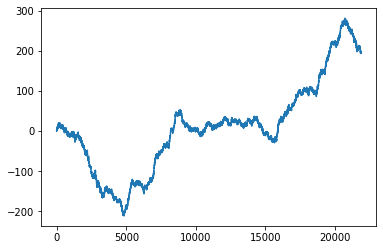

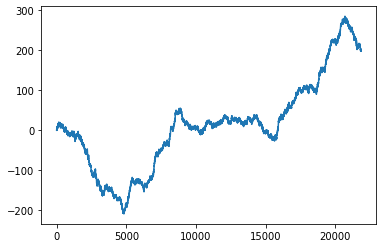

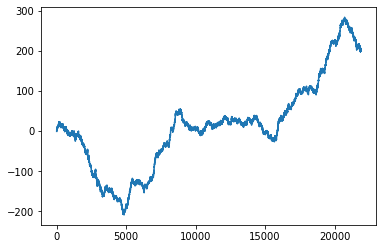

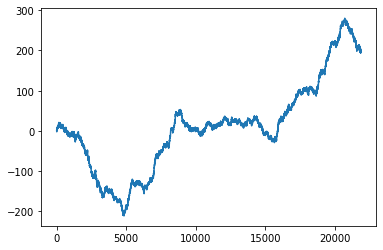

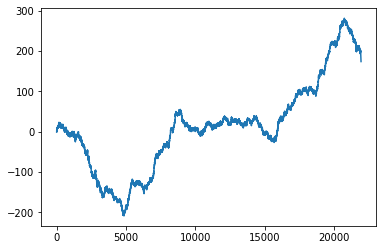

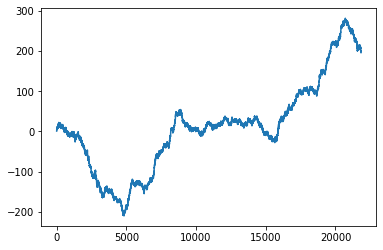

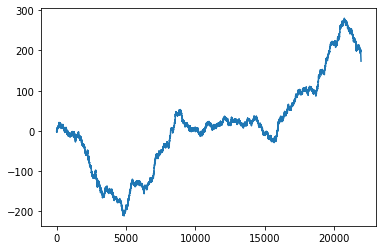

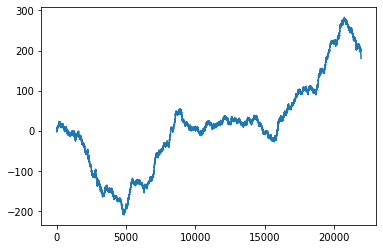

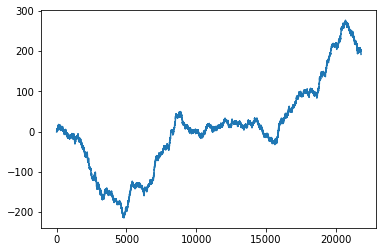

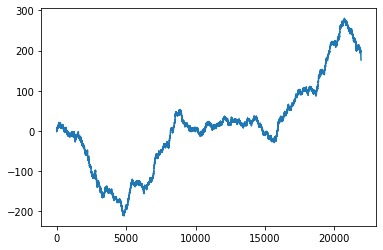

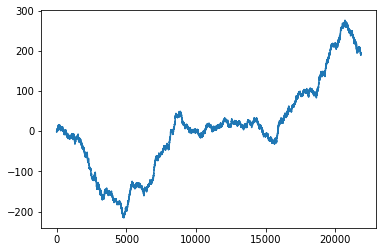

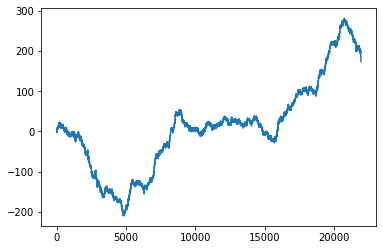

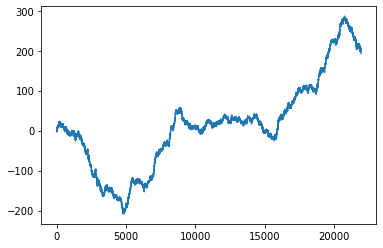

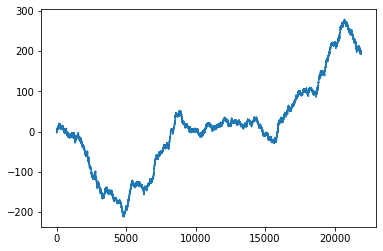

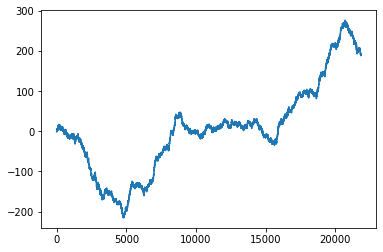

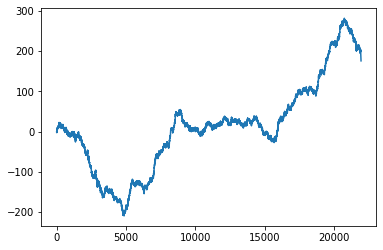

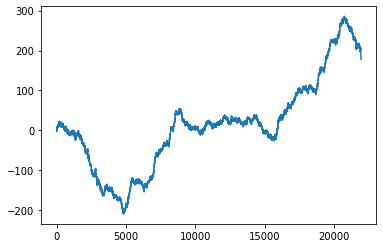

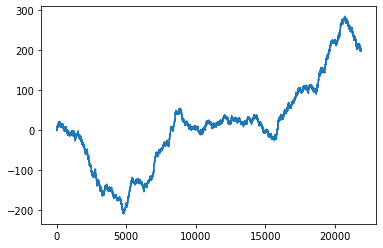

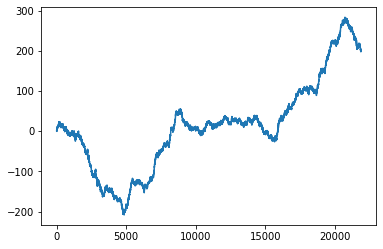

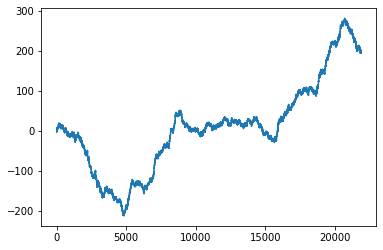

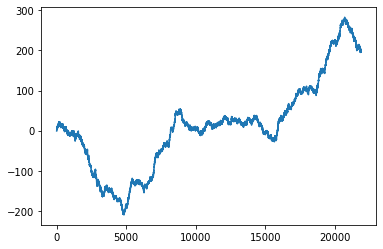

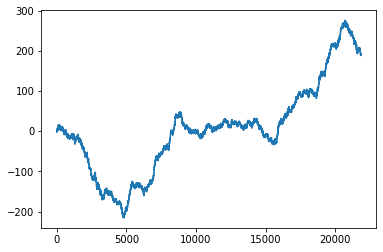

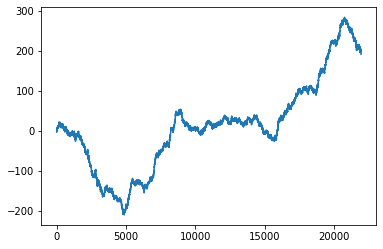

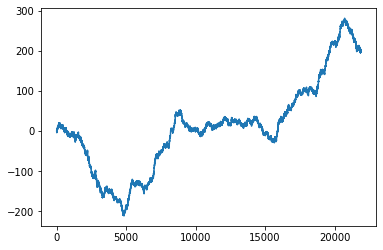

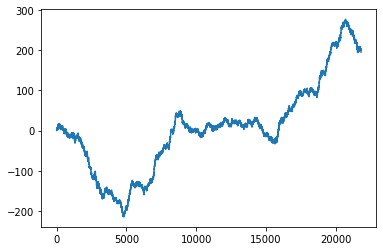

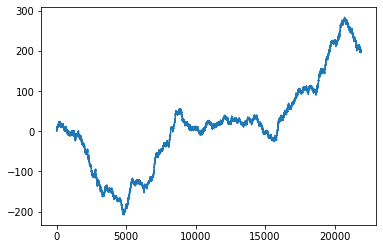

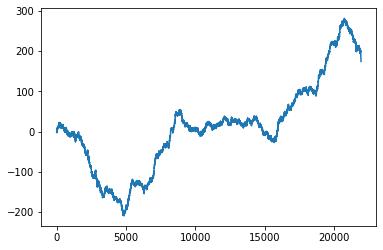

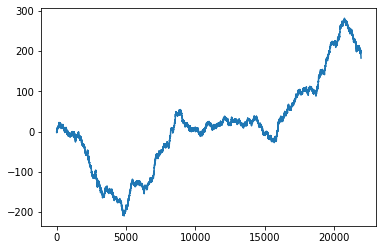

In [56]:
def PlotAll(AllX, AllY):
    for i in range(len(AllX)):
        Xi=AllX[i]
        Yi=AllY[i]
        plt.plot(Xi, Yi)
        plt.show()

PlotAll(Xs, Ys)

In [19]:
#erg0=0
#Xs0, Ys0 = calCenter(Xs[0],Ys[0])
#for i in range(len(Xs[0])):
#    erg0+=Xs[0][i]-Xs0*Ys[0][i]-Ys0
#erg0
# 17116867982.10221

### Code Equations from the Paper and Calculate the Distance Matrix

In [57]:
# coordinates of the geometrical center of the points
def calCenter(X,Y):
    X0=sum(X)/len(X) # <- was sum(X)/len(Xs), is now sum(X)/len(X)
    Y0=sum(Y)/len(Y) # <- was sum(Y)/len(Ys), is now sum(Y)/len(Y)
    return X0, Y0

# formula of the covariance matrix CM
def CMsum(X,Y):
    X0, Y0 = calCenter(X,Y)
    erg=0
    for i in range(len(X)):
        erg+=(X[i]-X0)*(Y[i]-Y0) # has now brackets instead of X[i]-X0*Y[i]-Y0
    return erg/len(X)

# the elements of the covariance matrix CM of the points 
def calCM(X,Y):
    CM=np.zeros((2,2))
    CM[0,0]=CMsum(X,X)
    CM[1,1]=CMsum(Y,Y)
    CM[1,0]=CMsum(X,Y)
    CM[0,1]=CM[1,0]
    return CM
    
print(calCM(Xs[0], Ys[0]))
print(calCM(Xs[0], Ys[0]).transpose().dot(calCM(Xs[0], Ys[0])))
print(calCM(Xs[1], Ys[1]))
print(calCM(Xs[2], Ys[2]))

[[3.98805540e+07 5.65611677e+05]
 [5.65611677e+05 1.22840537e+04]]
[[1.59077851e+15 2.25638550e+13]
 [2.25638550e+13 3.20067467e+11]]
[[3.98574960e+07 5.69534736e+05]
 [5.69534736e+05 1.24351253e+04]]
[[3.96689325e+07 5.79359811e+05]
 [5.79359811e+05 1.26501158e+04]]


In [58]:
#CM1=calCM(Xs[0],Ys[0])
#eigwert, eigvec = la.eig(CM1)
#print(eigwert)
#print(eigvec)

def distanceCentersIJ(Xi, Yi, Xj, Yj):
    xi0, yi0 = calCenter(Xi,Yi)
    xj0, yj0 = calCenter(Xj,Yj)
    return math.sqrt((xi0-xj0)**2+(yi0-yj0)**2)

def ThetaIJ(CM_i, CM_j):
    eigwert_i, EV_i = la.eig(CM_i)
    eigwert_j, EV_j = la.eig(CM_j)
    erg=math.acos(EV_i[0].dot(EV_j[0])/(np.linalg.norm(EV_i[0])*np.linalg.norm(EV_j[0])))+math.acos(EV_i[1].dot(EV_j[1])/(np.linalg.norm(EV_i[1])*np.linalg.norm(EV_j[1])))
    return erg

def DistanceIJ(Xi, Yi, Xj, Yj):
    CM_i=calCM(Xi, Yi)
    CM_j=calCM(Xj, Yj)
    return distanceCentersIJ(Xi, Yi, Xj, Yj) * ThetaIJ(CM_i, CM_j)
    

#print(ThetaIJ(calCM(Xs[0], Ys[0]),calCM(Xs[1], Ys[1])))
print(DistanceIJ(Xs[0], Ys[0], Xs[1], Ys[1])==DistanceIJ(Xs[1], Ys[1], Xs[0], Ys[0]))

def genDistanceMatrix(Xs, Ys):
    DM=np.zeros((len(Xs), len(Xs)))
    for i in range(len(Xs)):
        for j in range(len(Xs)):
            if i==j:
                DM[i,j]=0
            else:
                DM[i,j]=DistanceIJ(Xs[i], Ys[i], Xs[j], Ys[j])
    return DM

DistanceM=genDistanceMatrix(Xs, Ys)
print(DistanceM)

True
[[0.00000000e+00 1.75835677e-03 2.82675340e-02 ... 2.54636875e-03
  4.64832257e-03 4.16451993e-03]
 [1.75835677e-03 0.00000000e+00 1.65428626e-02 ... 1.39434515e-03
  3.11703592e-03 2.62116443e-03]
 [2.82675340e-02 1.65428626e-02 0.00000000e+00 ... 3.41821552e-02
  4.68729566e-02 4.35168928e-02]
 ...
 [2.54636875e-03 1.39434515e-03 3.41821552e-02 ... 0.00000000e+00
  3.04955109e-04 1.70181186e-04]
 [4.64832257e-03 3.11703592e-03 4.68729566e-02 ... 3.04955109e-04
  0.00000000e+00 1.96067254e-05]
 [4.16451993e-03 2.62116443e-03 4.35168928e-02 ... 1.70181186e-04
  1.96067254e-05 0.00000000e+00]]


### Use Distance Matrix to genarate the Tree

In [59]:
accession_metainfo = pd.read_csv("sequences47.csv", sep=',')
accession_metainfo.head()

,Accession,Release_Date,Species,Length,Geo_Location,Host,Isolation_Source,Collection_Date
0,MT641661,2020-06-19T00:00:00Z,Severe acute respiratory syndrome-related coro...,29818,Australia: Northern Territory,Homo sapiens,NaN,2020-03-24
1,MT450974,2020-05-11T00:00:00Z,Severe acute respiratory syndrome-related coro...,29802,Australia: Victoria,Homo sapiens,NaN,2020-03-13
2,MT509958,2020-05-25T00:00:00Z,Severe acute respiratory syndrome-related coro...,29724,Bangladesh,Homo sapiens,NaN,2020-05-11
3,MT601292,2020-06-12T00:00:00Z,Severe acute respiratory syndrome-related coro...,29883,Bangladesh: Dhaka,Homo sapiens,oronasopharynx,2020-06-01
4,MT350282,2020-04-17T00:00:00Z,Severe acute respiratory syndrome-related coro...,29903,Brazil,Homo sapiens,NaN,2020-03-18


In [60]:
len(ids)

47

In [61]:
len(Ys)

47

In [62]:
ids = accession_metainfo['Accession'].tolist()
def newDistanceMatrix(Xs, Ys, ids):
    matrix = []
    for i in range(len(Xs)):
        newrow=[]
        for j in range(len(Xs)):
            if i==j:
                newrow.append(0)
                matrix.append(newrow)
                break
            else:
                newrow.append(DistanceIJ(Xs[i], Ys[i], Xs[j], Ys[j]))
    #matrix=matrix[1:]
    print(len(ids))
    print(len(matrix))
    dm = _DistanceMatrix(ids, matrix)
    return dm

curveDM=newDistanceMatrix(Xs, Ys, ids)
type(curveDM)

47
47


Bio.Phylo.TreeConstruction.DistanceMatrix

In [71]:
constructor = DistanceTreeConstructor()
tree = constructor.upgma(curveDM)
code=accession_metainfo['Accession']
host=accession_metainfo["Host"]
loc=accession_metainfo["Geo_Location"]

In [74]:
# function for the phylogenetic tree labels
def get_label(leaf):
    searchname=leaf.name
    for i in range(0, len(code)):
        if searchname==code[i] or searchname + ".1" ==code[i]:
            name=host[i] + ": " + loc[i]
            return name

In [72]:
print(tree)

Tree(rooted=True)
    Clade(branch_length=0, name='Inner46')
        Clade(branch_length=0.011002025071228688, name='MT509958')
        Clade(branch_length=0.010619812299079082, name='Inner45')
            Clade(branch_length=0.0027932775018917858, name='Inner43')
                Clade(branch_length=0.001596848090439401, name='Inner39')
                    Clade(branch_length=0.0006554931116665559, name='Inner18')
                        Clade(branch_length=4.584551166001223e-05, name='MT675958')
                        Clade(branch_length=4.584551166001223e-05, name='MT569471')
                    Clade(branch_length=0.00042665224535949994, name='Inner32')
                        Clade(branch_length=0.0002746863779670682, name='MT447175')
                        Clade(branch_length=0.0002746863779670682, name='MT675933')
                Clade(branch_length=0.0016826140065171876, name='Inner38')
                    Clade(branch_length=0.00045150529599144917, name='Inner30')
           

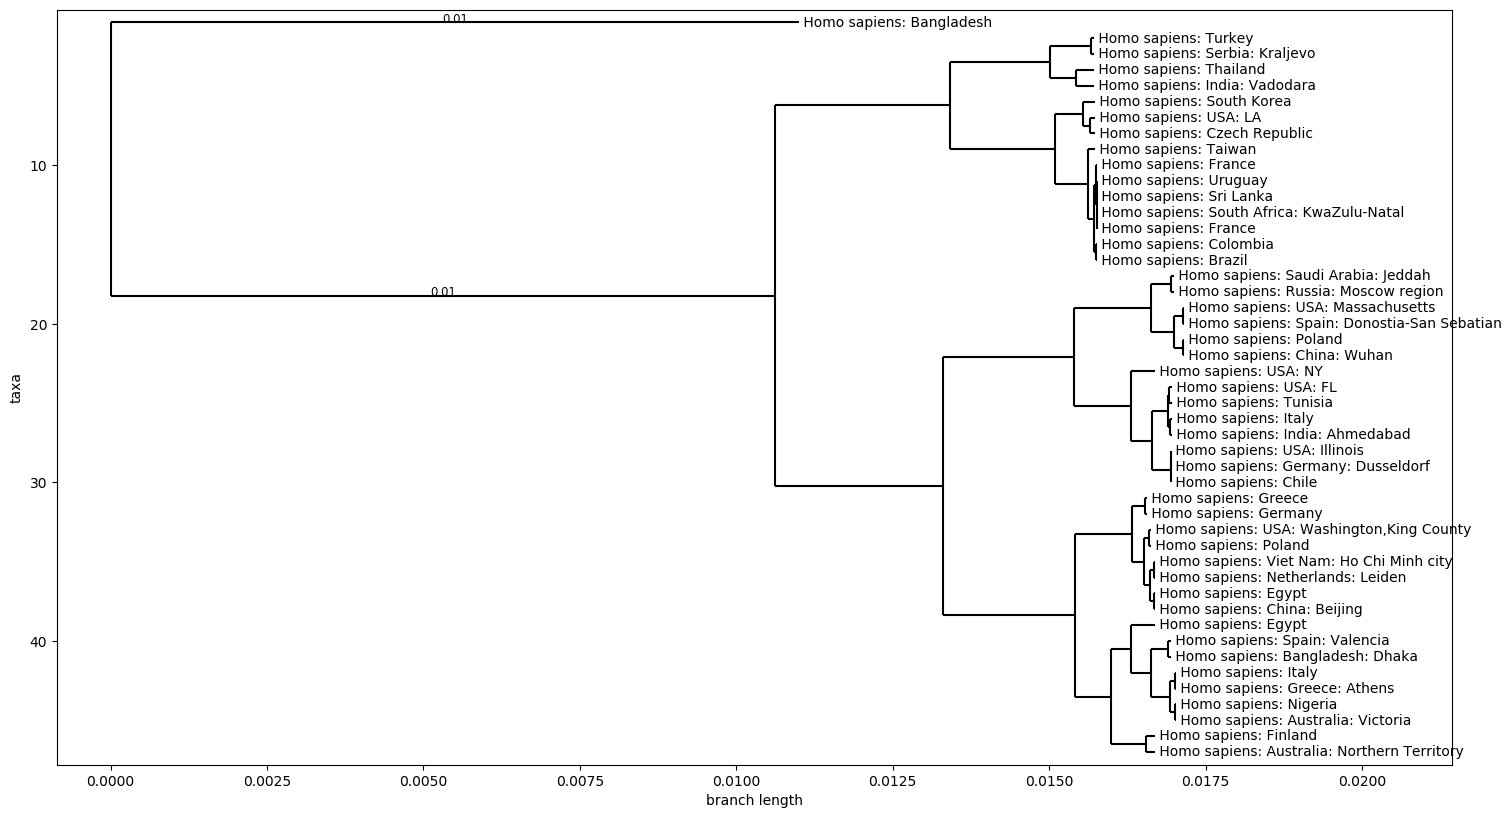

In [75]:
fig = plt.figure(figsize=(18, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)

Phylo.draw(tree, axes=axes, label_func=get_label, branch_labels=lambda c: round(c.branch_length, 2), do_show=False)
plt.savefig('Curve_UPGMA_tree.png')

# Stuff from last week 

### Read the unaligned sequences and process them

In [3]:
 align = AlignIO.read("MSA47.fasta", "fasta")

### Process metadata 

The metadata file was downloaded from https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&ids=MN908947%20MG772933%20MT658507%20MT576584%20MT582453%20MT525950%20MT641501%20MT350282%20MT263074%20MT641645%20MT451694%20MT635269 .

For TreeTime and Nextstrain augur:
- matched MSA sequence names and accession ids in  metadata file
- renamed collection date column in metadata to "date" (datetime format)


For Nextstrain augur refine:
- created the columns "strain" and "virus" in addition to "date" (strain = accession, virus = species)
(https://nextstrain.org/docs/tutorials/zika)

In [4]:
accession_metainfo_align = pd.read_csv("sequences47.csv", sep=",")
accession_metainfo_align.head()

,Accession,Release_Date,Species,Length,Geo_Location,Host,Isolation_Source,Collection_Date
0,MT641661,2020-06-19T00:00:00Z,Severe acute respiratory syndrome-related coro...,29818,Australia: Northern Territory,Homo sapiens,NaN,2020-03-24
1,MT450974,2020-05-11T00:00:00Z,Severe acute respiratory syndrome-related coro...,29802,Australia: Victoria,Homo sapiens,NaN,2020-03-13
2,MT509958,2020-05-25T00:00:00Z,Severe acute respiratory syndrome-related coro...,29724,Bangladesh,Homo sapiens,NaN,2020-05-11
3,MT601292,2020-06-12T00:00:00Z,Severe acute respiratory syndrome-related coro...,29883,Bangladesh: Dhaka,Homo sapiens,oronasopharynx,2020-06-01
4,MT350282,2020-04-17T00:00:00Z,Severe acute respiratory syndrome-related coro...,29903,Brazil,Homo sapiens,NaN,2020-03-18


# Infer phlyogeny
### Based on the MSA, a distance matrix is calculated for the 47 SARS-CoV2 sequences using the identity substitution model.

The identity substitution model assumes that each RNA base can only be maximally similar to itself but not transform into another base. Based on this assumption, two positions in a genomic MSA can only be considered identical (score = 1) or different (score = 0).

- Reading alignments, computing distance matrix, applying and visualizin UPGMA-inferred phylogeny: https://github.com/simonjuleseric2/covid_sequence/blob/master/coronavirus_sequence_analis.ipynb


In [5]:
calculator = DistanceCalculator('identity')
# output = diagonal distance matrix
dm = calculator.get_distance(align)

In [6]:
type(dm)

Bio.Phylo.TreeConstruction.DistanceMatrix

### Infer phylogeny using the UPGMA algorithm

UPGMA:
- distance based
- bottom-up hierarchical
- assumes a constant mutation rate

Goal:
- get general phylogeny of the SARS-CoV-2 genomes only based on sequence distance

In [9]:
constructor_upgma = DistanceTreeConstructor()
tree_upgma = constructor_upgma.upgma(dm)

#
code_upgma=accession_metainfo_align["Accession"]
host_upgma=accession_metainfo_align["Host"]
loc_upgma=accession_metainfo_align["Geo_Location"]

In [18]:
# function for the phylogenetic tree labels
def get_label_upgma(leaf):
    if "|" in leaf.name:
        searchname=leaf.name.split("|")[1]
    else:
        searchname=leaf.name
    for i in range(0, len(code_upgma)):
        if searchname==code_upgma[i] or searchname==code_upgma[i] + ".1" or searchname==code_upgma[i] + ".2":
            name=host_upgma[i] + ": " + loc_upgma[i]
            return name

In [11]:
print(tree_upgma)

Tree(rooted=True)
    Clade(branch_length=0, name='Inner46')
        Clade(branch_length=0.0029822745235636855, name='gb|MT509958.1')
        Clade(branch_length=0.0020793550840425418, name='Inner45')
            Clade(branch_length=0.0013217304126277897, name='Inner40')
                Clade(branch_length=0.00021230755484399758, name='Inner36')
                    Clade(branch_length=0.0006521084840985791, name='gb|MT630425.1')
                    Clade(branch_length=0.0006521084840985791, name='gb|MT291827.1')
                Clade(branch_length=0.0004151770411831506, name='Inner37')
                    Clade(branch_length=0.0003526539195482304, name='Inner31')
                        Clade(branch_length=0.00018549560244793522, name='Inner28')
                            Clade(branch_length=0.00016720730361503844, name='Inner24')
                                Clade(branch_length=7.524328662678048e-05, name='Inner19')
                                    Clade(branch_length=0.0002675

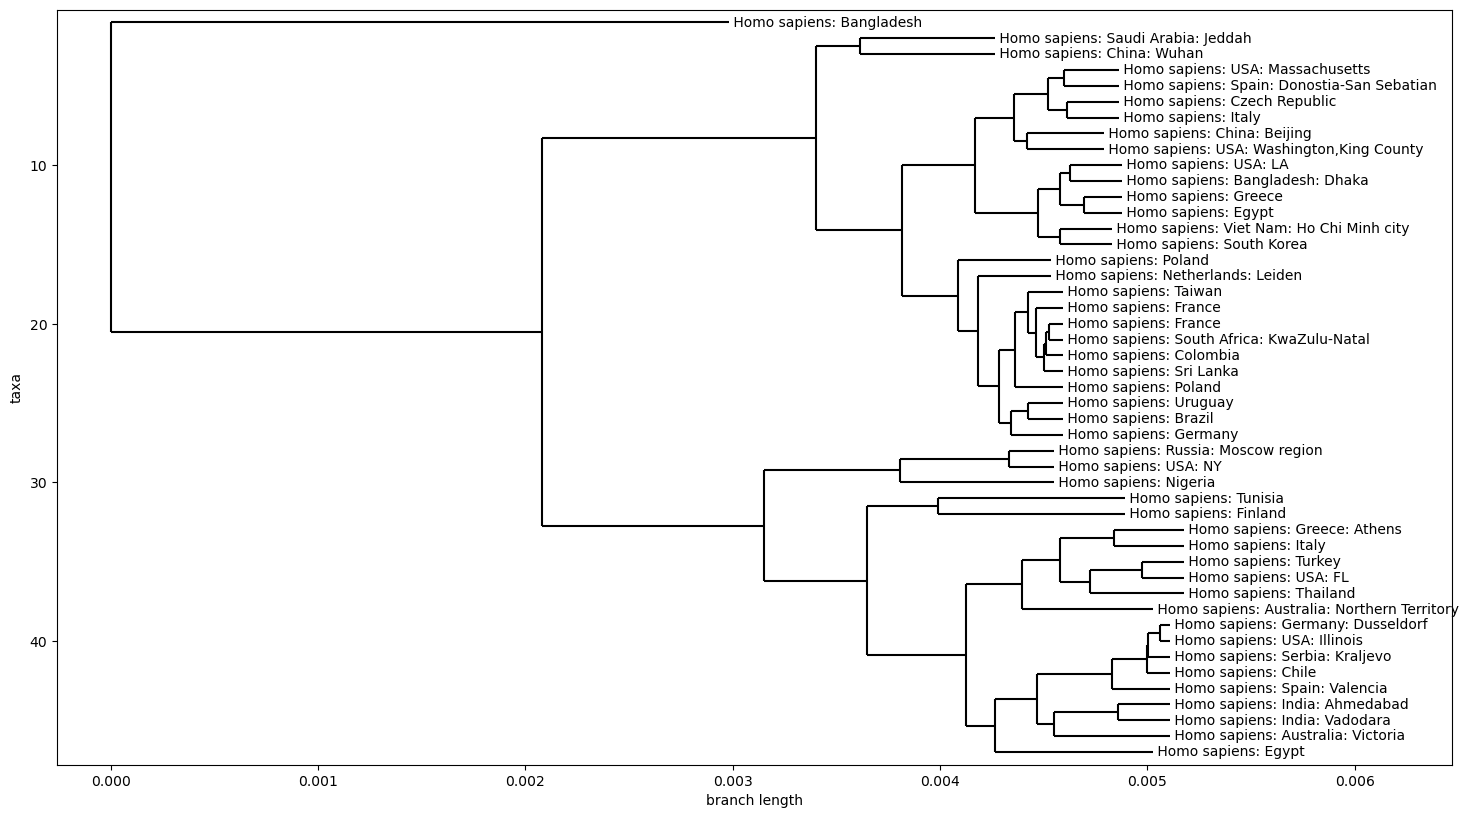

In [19]:
fig = plt.figure(figsize=(18, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)

Phylo.draw(tree_upgma, axes=axes, label_func=get_label_upgma, branch_labels=lambda c: round(c.branch_length, 2), do_show=False)
plt.savefig('UPGMA_tree.png')
